In [1]:
adfile_path = r"C:\Users\21lyb\Downloads\PBMC_simulated_cnas_041025.h5ad"

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
from biomart import BiomartServer
from io import StringIO
import anndata as ad
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from hmmlearn import hmm
import warnings

warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

sc.logging.print_header()

Package,Version
numpy,1.26.4
pandas,2.2.3
scanpy,1.11.1
infercnvpy,0.6.0
matplotlib,3.10.0
biomart,0.9.2
anndata,0.11.4
scikit-learn,1.5.2
scipy,1.15.2
hmmlearn,0.3.3


In [3]:
# Functions
def fetch_positions(adata):
    # Connect to Ensembl Biomart server
    server = BiomartServer("http://grch37.ensembl.org/biomart")
    dataset = server.datasets['hsapiens_gene_ensembl']

    # Query gene names for only missing gene positions
    no_positions = adata[:, adata.var[['start', 'end']].isna().any(axis=1)]
    with_positions = adata[:, ~adata.var[['start', 'end']].isna().any(axis=1)]
    response = dataset.search({
        'filters':{'ensembl_gene_id':list(no_positions.var['gene_ids'])},
        'attributes':['ensembl_gene_id','chromosome_name','start_position','end_position','strand']
    })

    # Convert response to DataFrame and merge with adata.var if response is successful
    if response.status_code == 200:
        print("Request successful!")
        gene_annotations_df = pd.read_csv(StringIO(response.text),sep='\t',header=None)
        gene_annotations_df.columns = ['gene_ids','chromosome','start','end','strand']
    else:
        print(f"Request failed with status code: {response.status_code}")
        print(response.text)

    # Isolate fetched genes from BioMart in no_positions adata
    fetched_positions = no_positions[:, no_positions.var['gene_ids'].isin(gene_annotations_df['gene_ids'])].copy()

    # Sort fetched genes based on ensembl gene IDs
    fetched_positions = fetched_positions[:, fetched_positions.var['gene_ids'].argsort()].copy()

    # Add the fetched gene positions to the adata
    fetched_positions.var['chromosome'] = gene_annotations_df['chromosome'].values
    fetched_positions.var['start'] = gene_annotations_df['start'].values
    fetched_positions.var['end'] = gene_annotations_df['end'].values
    fetched_positions.var['strand'] = gene_annotations_df['strand'].values

    # Concatenate fetched genes with isolated genes already with positions
    adClean = ad.concat([with_positions, fetched_positions], axis=1)

    # Include obs into the cleaned adata
    adClean.obs = with_positions.obs.copy()

    return adClean

def standardize_chromosomes(adata):
    
    adata1 = adata.copy()

    # Add 'chr' prefix to chromosome names
    adata1.var['chromosome'] = 'chr' + adata1.var['chromosome'].astype(str)

    # Define standard chromosome names with 'chr' prefix
    standard_chromosomes = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY', 'chrMT']

    # Filter adata to include only genes on standard chromosomes
    adata1 = adata1[:, adata1.var['chromosome'].isin(standard_chromosomes)].copy()

    return adata1

def qc(adata,
    mt_threshold_pct=20,
    min_genes=200,
    max_counts=50000,
    min_cells=3):

    adata1 = adata.copy()

    # Find MT genes
    adata1.var['mt'] = adata1.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'],
                            percent_top=None,
                            log1p=False,
                            inplace=True)

    # Filter out cells based on MT genes
    adClean = adata1[adata1.obs['pct_counts_mt']<mt_threshold_pct,:].copy()

    # Filter out cells based on number of genes expressed
    sc.pp.filter_cells(adClean, min_genes=min_genes)

    # Filter out cells based on total counts
    sc.pp.filter_cells(adClean, max_counts=max_counts)

    # Filter out genes expressed in few cells
    sc.pp.filter_genes(adClean, min_cells=min_cells)

    return adClean


def log_freeman_tukey_transform(expr_mat):
    """
    Freeman-Tukey variance stabilizing transformation:
    log2(sqrt(x) + sqrt(x+1))
    """
    return np.log2(np.sqrt(expr_mat) + np.sqrt(expr_mat + 1))

def identify_diploid_cells_high_precision(adata,
                                           window=10,
                                           n_components=3,
                                           n_pcs=20,
                                           primary_trim_percentile=100,
                                           secondary_trim_percentile=30):
    """
    Identify diploid cells by:
    - Selecting lowest-variance GMM cluster (primary)
    - Adding central portion of second-lowest variance cluster (secondary)
    - Based on PCA + GMM and genomic smoothing
    """
    expr_raw = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    expr_df = pd.DataFrame(expr_raw, index=adata.obs_names, columns=adata.var_names)
    gene_order = adata.var.sort_values(['chromosome', 'start']).index
    expr_df = expr_df[gene_order]

    # Smoothing
    expr_smooth = expr_df.T.rolling(window=window, min_periods=1, center=True).mean().dropna().T
    expr_smooth = expr_smooth.loc[:, ~expr_smooth.columns.duplicated()]

    # PCA
    pca = PCA(n_components=n_pcs)
    pcs = pca.fit_transform(expr_smooth)

    # GMM Clustering
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    labels = gmm.fit_predict(pcs)

    # Rank clusters by composite score = variance × size
    cluster_variances = [expr_smooth.iloc[labels == i].var(axis=1).mean() for i in range(n_components)]
    cluster_sizes = [np.sum(labels == i) for i in range(n_components)]
    composite_score = [v * s for v, s in zip(cluster_variances, cluster_sizes)]
    sorted_clusters = np.argsort(composite_score)

    # --- PRIMARY cluster (lowest variance): take central X%
    primary_cluster = sorted_clusters[0]
    primary_idx = np.where(labels == primary_cluster)[0]
    primary_pcs = pcs[primary_idx]
    center1 = primary_pcs.mean(axis=0).reshape(1, -1)
    dist1 = cdist(primary_pcs, center1).flatten()
    thresh1 = np.percentile(dist1, primary_trim_percentile)
    keep_primary = primary_idx[dist1 <= thresh1]

    # --- SECONDARY cluster (2nd lowest variance): take tighter X%
    secondary_cluster = sorted_clusters[1]
    secondary_idx = np.where(labels == secondary_cluster)[0]
    secondary_pcs = pcs[secondary_idx]
    center2 = secondary_pcs.mean(axis=0).reshape(1, -1)
    dist2 = cdist(secondary_pcs, center2).flatten()
    thresh2 = np.percentile(dist2, secondary_trim_percentile)
    keep_secondary = secondary_idx[dist2 <= thresh2]

    # --- Combine both
    confident_indices = np.concatenate([keep_primary, keep_secondary])
    diploid_pred = np.zeros(pcs.shape[0], dtype=bool)
    diploid_pred[confident_indices] = True
    diploid_pred = ['diploid' if x else 'aneuploid' for x in diploid_pred]

    return diploid_pred, labels


def evaluate_predictions(adata, diploid_pred):
    """
    Compare predicted diploids vs. simulated CNV ground truth.
    Returns: precision, recall, F1 score.
    """
    true_diploid = adata.obs['simulated_cnvs'].astype(str).replace(['', 'nan', 'NaN'], np.nan).isna()
    tp = np.sum((diploid_pred == True) & (true_diploid == True))
    fp = np.sum((diploid_pred == True) & (true_diploid == False))
    fn = np.sum((diploid_pred == False) & (true_diploid == True))
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return precision, recall, f1

def downsample(adata,n_cells):
    if adata.n_obs <= n_cells:
        return adata
    else:
        return adata[np.random.choice(adata.obs_names, n_cells, replace=False), :].copy()
    
def cnv_plots(adata,annotation='cell_type'):
    cnv.tl.pca(adata)
    cnv.pp.neighbors(adata)
    cnv.tl.leiden(adata)

    sc.tl.dendrogram(adata, groupby='cnv_leiden')

    cnv.tl.umap(adata)
    cnv.tl.cnv_score(adata)


    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
    ax4.axis("off")
    cnv.pl.umap(
        adata,
        color="cnv_leiden",
        legend_loc="on data",
        legend_fontoutline=2,
        ax=ax1,
        show=False,
    )
    cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
    cnv.pl.umap(adata, color="cell_type", ax=ax3)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 11), gridspec_kw={"wspace": 0.5})
    ax4.axis("off")
    sc.pl.umap(adata, color="cnv_leiden", ax=ax1, show=False)
    sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
    sc.pl.umap(adata, color="cell_type", ax=ax3)
    
def CNV_ttest(adata,CNV_clusters,plot=False):
    sc.tl.rank_genes_groups(adata,use_raw=False,groupby='cnv_leiden',layer='gene_values_cnv',method='t-test')
    sc.tl.dendrogram(adata, groupby='cnv_leiden')
    if plot:
        for cluster in CNV_clusters:
            sc.pl.rank_genes_groups_dotplot(adata,
                                            n_genes=10,
                                            groupby="cnv_leiden",
                                            dendrogram=True,
                                            key='rank_genes_groups',
                                            groups=[str(cluster)])

def get_cnv_genes(adata,cluster):
    # Get top genes for each CNV cluster that share the same chromosome and are in proximity
    ranked_genes = adata.uns['rank_genes_groups']
    genes = []
    chr = adata.var['chromosome'][ranked_genes['names'][str(cluster)][0]]
    for gene in ranked_genes['names'][str(cluster)]:
        if adata.var['chromosome'][gene] == chr:
            genes.append(gene)
        else:
            break

    # Sort genes by their start position
    genes = sorted(genes, key=lambda x: adata.var['start'][x])

    return genes
        
def annotate_cnv(adata,CNV_clusters):
    adata1 = adata.copy()

    # Reference/background cells in adata that aren't in any CNV clusters
    reference_adata = adata1[~adata1.obs['cnv_leiden'].isin([str(x) for x in CNV_clusters]),:].copy()

    for cluster in CNV_clusters:
        # Get CNV genes for the cluster
        cnv_genes = get_cnv_genes(adata1,str(cluster))

        # If no genes found for the cluster, return None
        if len(cnv_genes)==0:
            return adata
        
        # Calculate mean expression for the cluster's cells
        cluster_cells = adata1.obs['cnv_leiden']==str(cluster)
        cluster_mean = adata1[cluster_cells,cnv_genes].X.mean(axis=0)

        # Calculate mean expression for all cells excluding CNV clusters
        reference_mean = reference_adata[:,cnv_genes].X.mean(axis=0)

        # Determine CNV type based on the mean expression (gain or loss)
        if np.mean(cluster_mean) > np.mean(reference_mean):
            cnv_type = 'gain'
        elif np.mean(cluster_mean) < np.mean(reference_mean):
            cnv_type = 'loss'
        else:
            return adata
        
        # Get chromosome, start, and end positions from the first and last genes in the cluster
        chr = adata1.var['chromosome'][cnv_genes[0]]
        start = adata1.var['start'][cnv_genes[0]]
        end = adata1.var['end'][cnv_genes[-1]]

        # For the cells of a cluster, add annotated CNV to adata.obs as chromosome:start-end (gain or loss)
        cnv_annotation = f"{chr}:{start}-{end} ({cnv_type})"
        
        # Add CNV annotation to the cells of the cluster
        adata1.obs.loc[adata1.obs['cnv_leiden']==str(cluster),'annotated_cnvs'] = cnv_annotation

    # In annotated_cnv, replace NaN with empty string
    adata1.obs['annotated_cnvs'] = adata1.obs['annotated_cnvs'].fillna('')

    return adata1

# Function to extract chromosome and type (gain/loss) from CNV annotation
def extract_cnv_info(cnv_annotation):
    if cnv_annotation:
        parts = cnv_annotation.split(" ")
        if len(parts) > 1:
            cnv_chr = parts[0].split(":")[0]
            cnv_start = parts[0].split(':')[1].split('-')[0]
            cnv_end = parts[0].split(':')[1].split('-')[1]
            cnv_type = parts[-1].strip("()")
            return cnv_chr,cnv_start,cnv_end,cnv_type
    return None, None

In [4]:
adata = sc.read_h5ad(adfile_path)

In [5]:
adata = fetch_positions(adata)

Request successful!


In [6]:
adata = standardize_chromosomes(adata)

In [7]:
# Run if needed:
# adata = qc(adata)
# adata = downsample(adata,n_cells=2000)

In [8]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)

In [9]:
diploid_pred,labels=identify_diploid_cells_high_precision(adata,window=10,n_components=3,primary_trim_percentile=100,secondary_trim_percentile=10)

adata.obs['predicted_diploid'] = diploid_pred
adata.obs['gmm_cluster'] = labels.astype(str)

In [10]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.125, max_mean=6, min_disp=0.25)

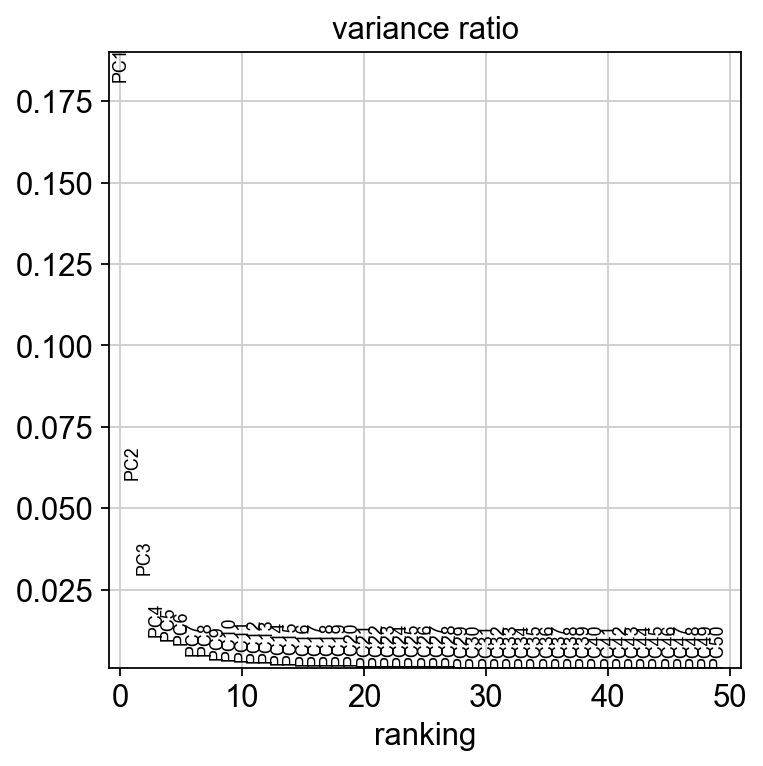

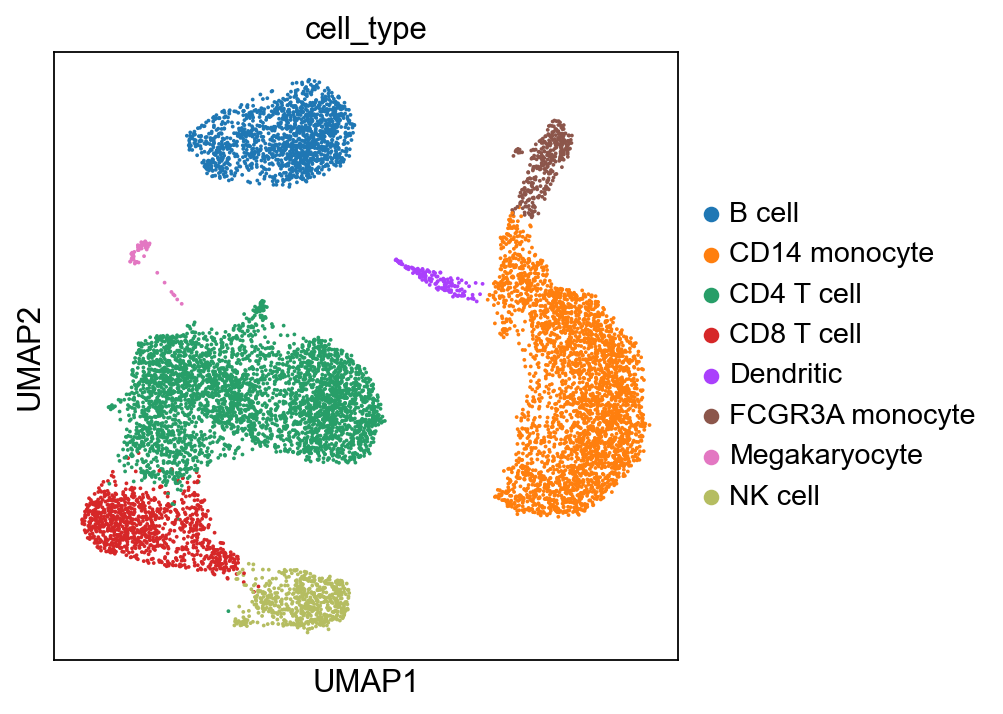

In [11]:
sc.tl.pca(adata, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata,50)

sc.pp.neighbors(adata,n_neighbors=20,n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')

In [12]:
# Sort adata by chromosome and start position
adata = adata[:,adata.var.sort_values(by=['chromosome','start']).index].copy()

In [13]:
reference_key = 'predicted_diploid'
reference_cat = ['diploid']
window_size = 100
step = 10
dynamic_threshold = 1.5

cnv.tl.infercnv(adata,reference_key=reference_key,reference_cat=reference_cat,
                exclude_chromosomes=None,chunksize=100,calculate_gene_values=True,
                window_size=window_size,step=step,dynamic_threshold=dynamic_threshold)

# Actual simulated CNVs:
# - CD14 monocytes: Chr6 loss, Chr22 loss
# - CD4 T cells: ChrX gain

  0%|          | 0/104 [00:00<?, ?it/s]

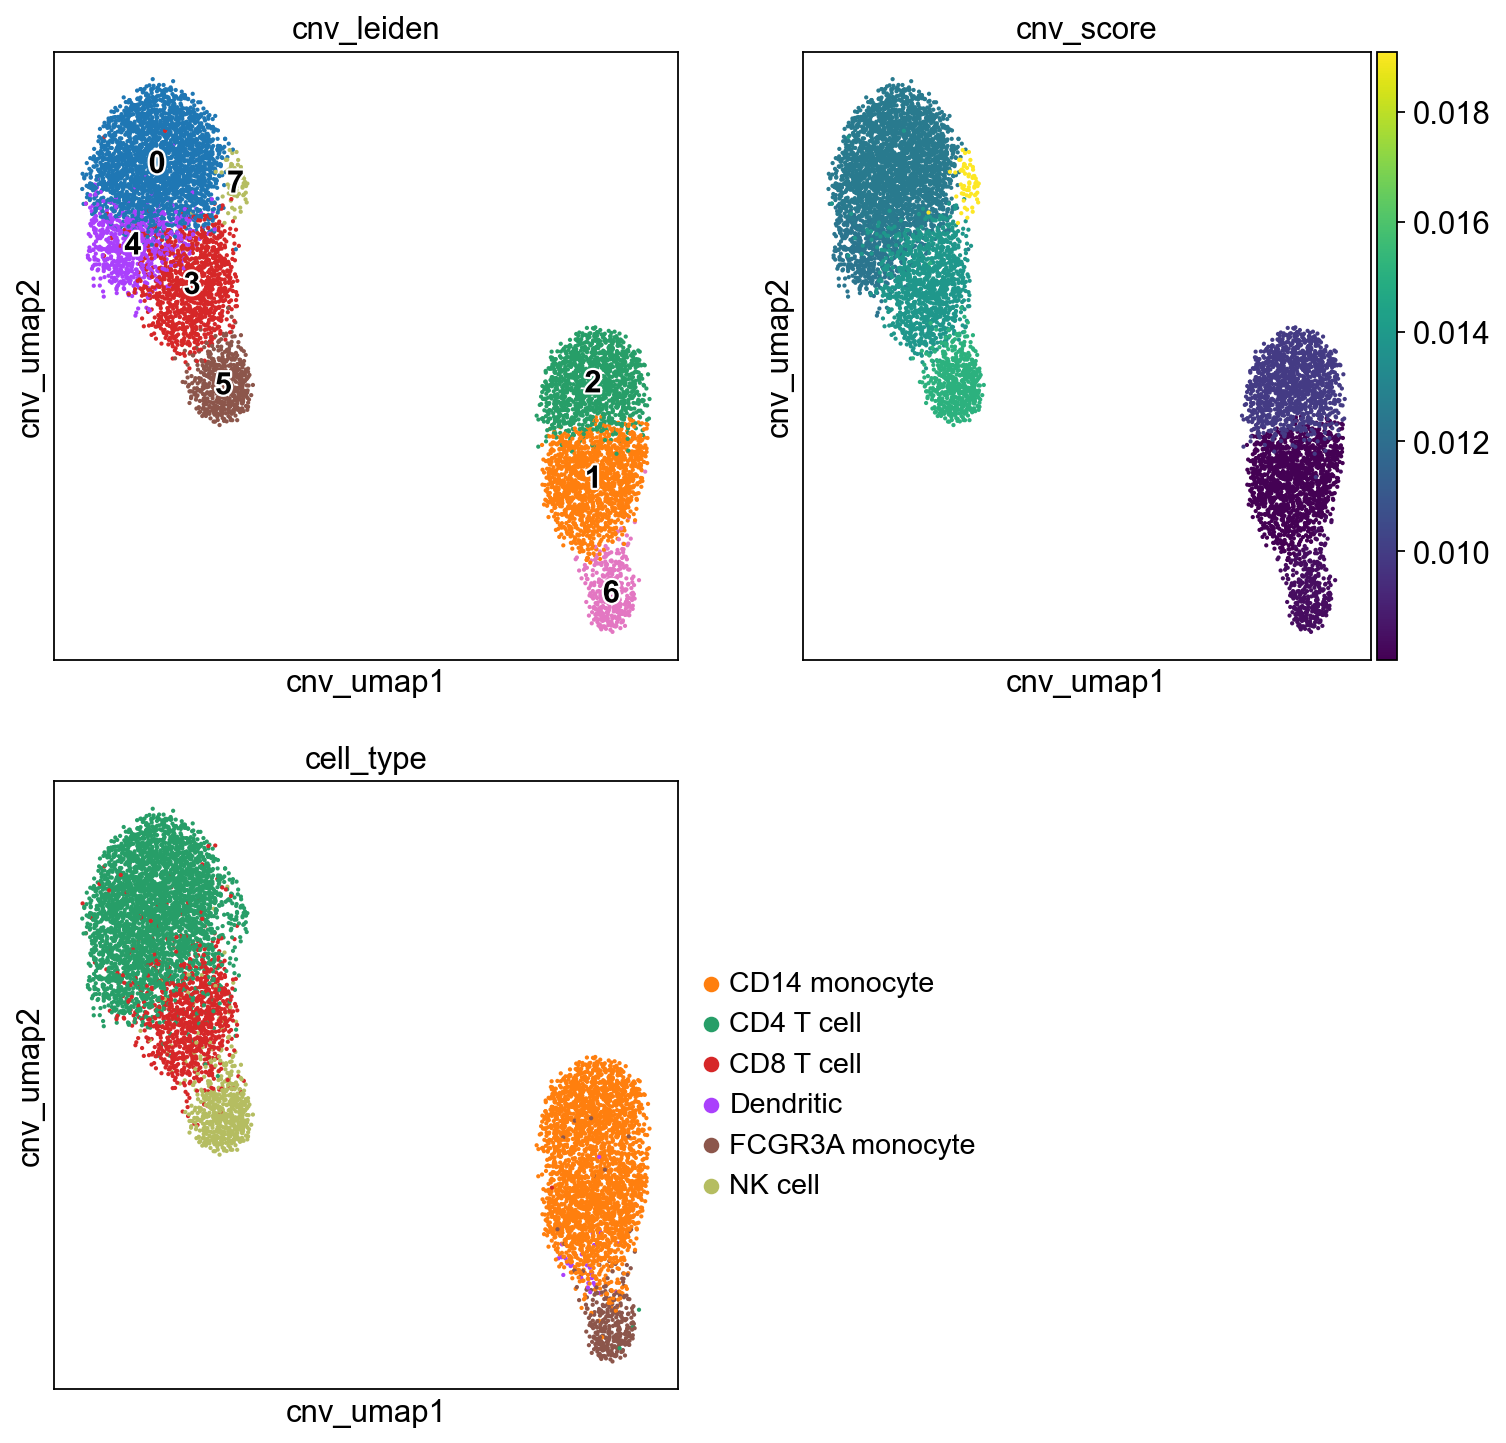

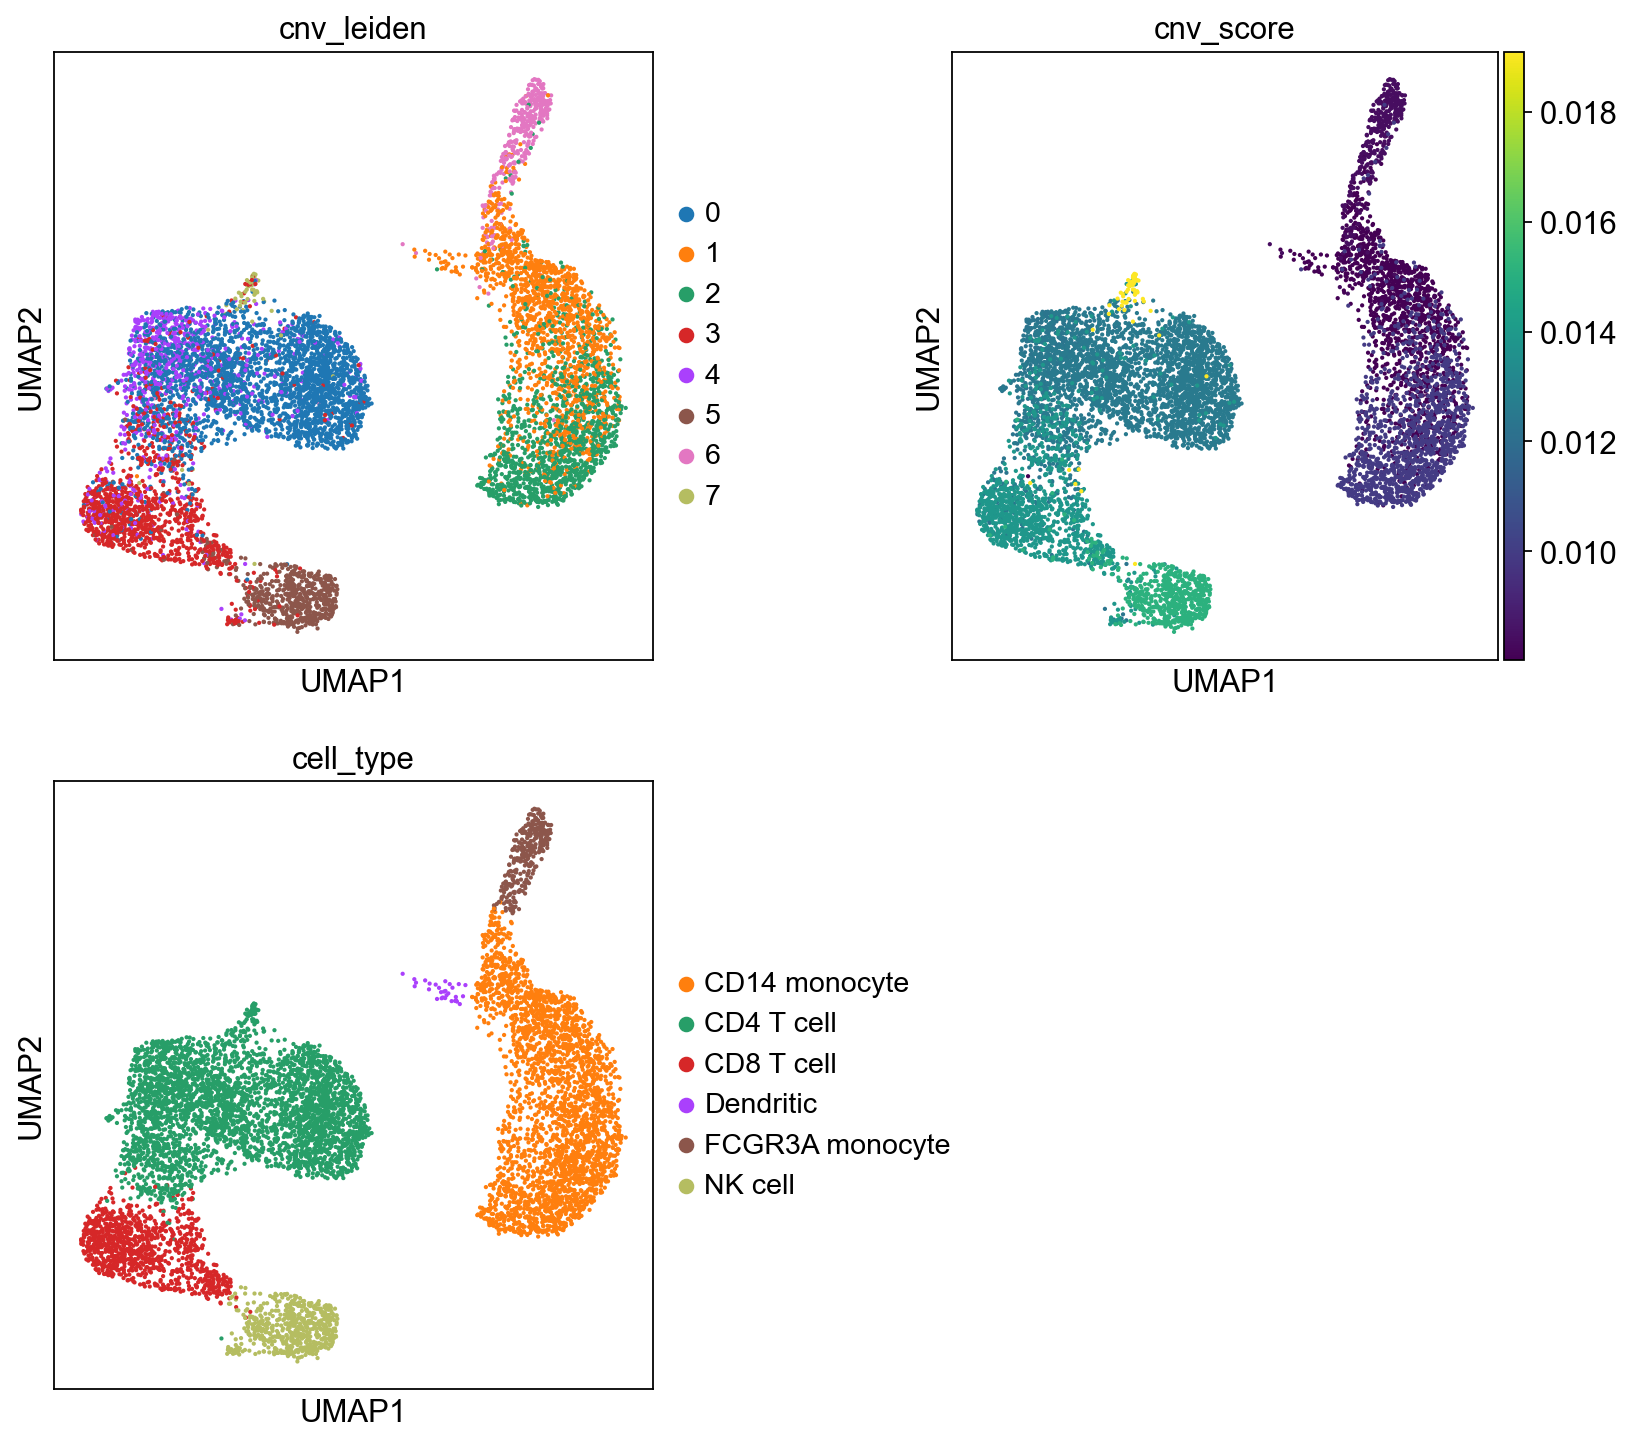

In [14]:
cnv_plots(adata[adata.obs['predicted_diploid']=='aneuploid'],annotation='cell_type')

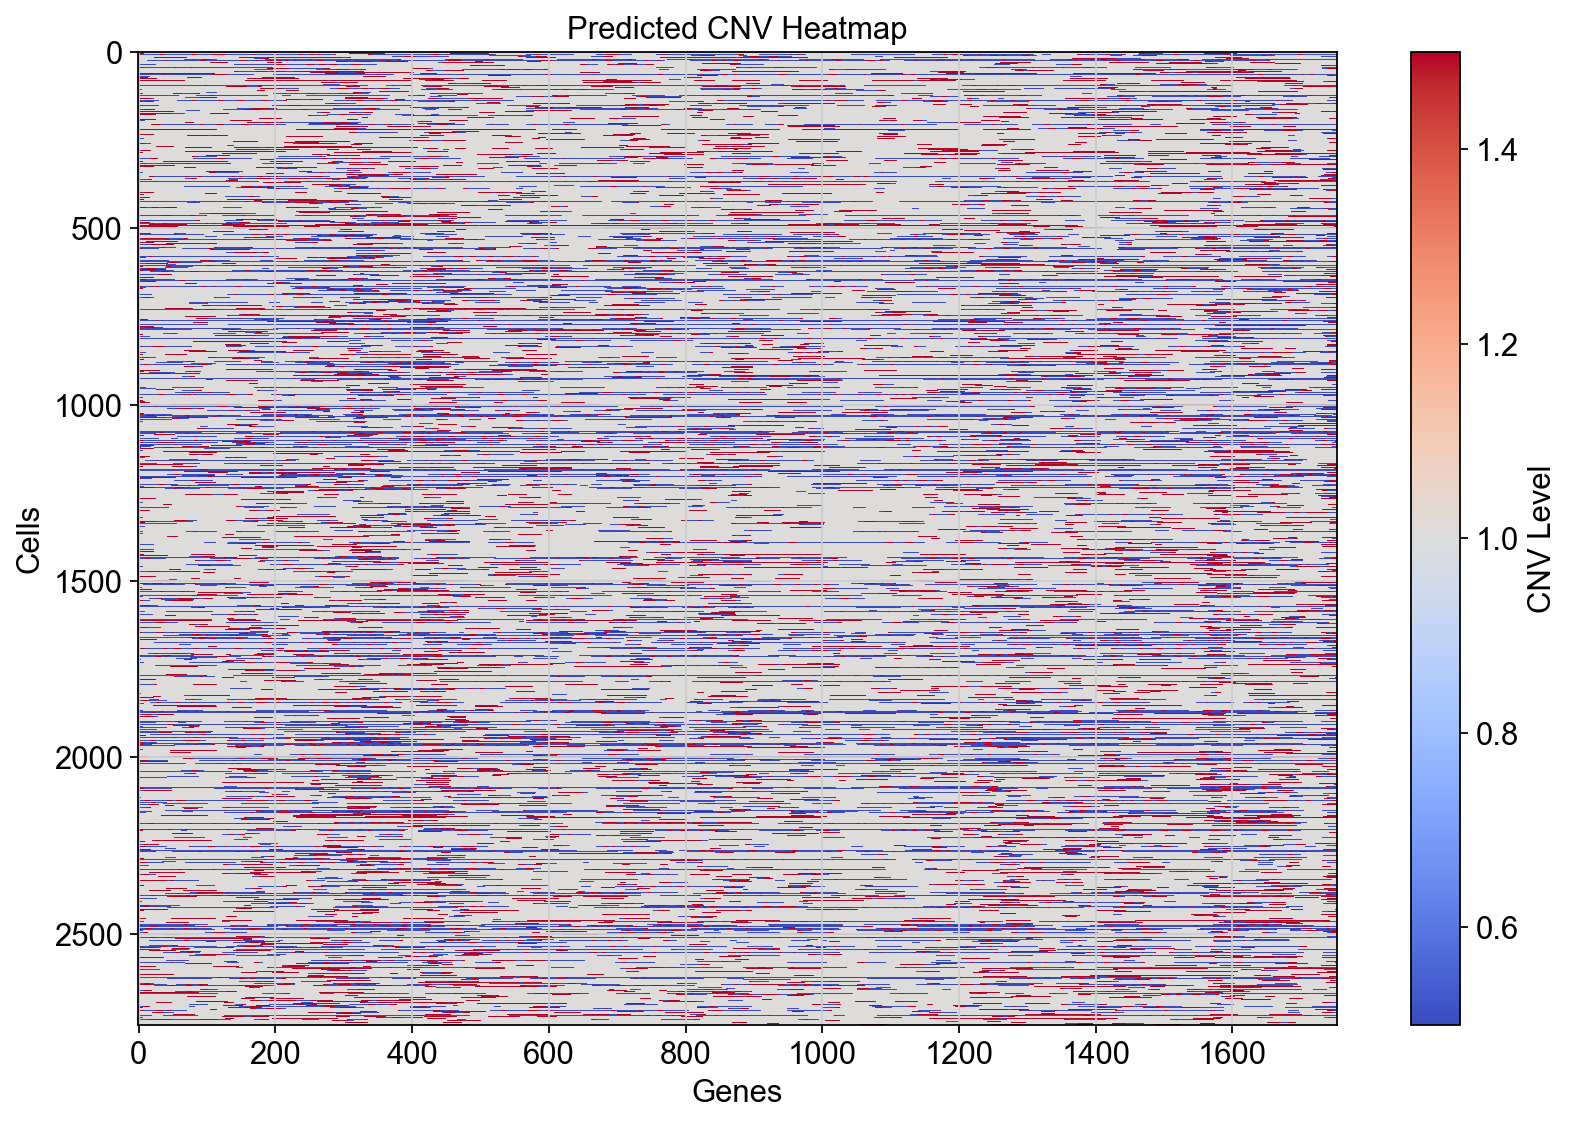

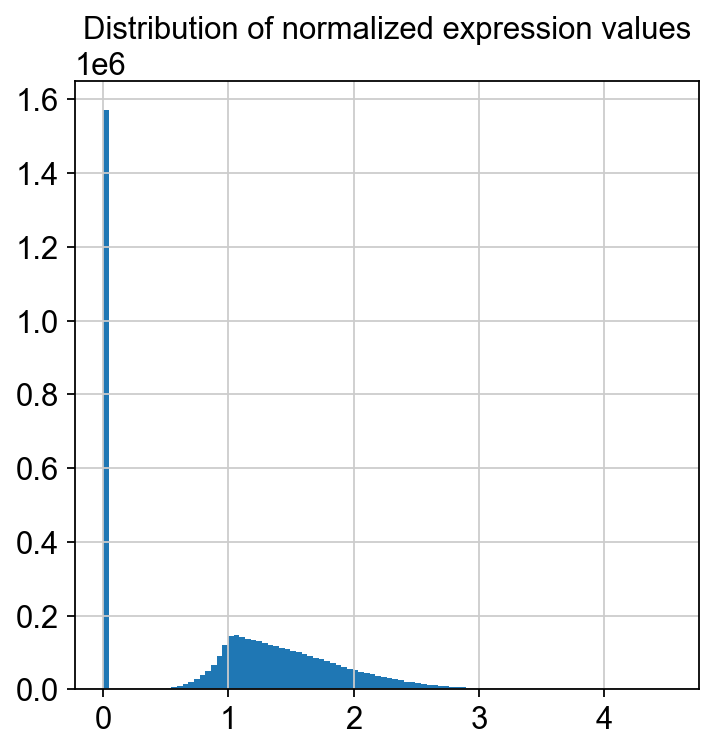

In [27]:
# Approach similar to 3-state Hidden Markov Model used by the R version of InferCNV to detect genomic regions

# Prepare your transition matrix and emission probabilities (mean, variance)
# Transition matrix (3x3) for states: Deletion (0.5), Neutral (1), Amplification (1.5)
# The transition matrix defines the probability of moving from one state to another. Here, the states are:
# 0 (Deletion), 1 (Neutral), and 2 (Amplification). The values indicate the transition probabilities between these states.

transition_matrix = np.array([
    [1 - 5 * 0.000001, 0.000001, 0.000001],  # Transition probabilities for state 0 (Deletion)
    [0.000001, 1 - 5 * 0.000001, 0.000001],  # Transition probabilities for state 1 (Neutral)
    [0.000001, 0.000001, 1 - 5 * 0.000001]   # Transition probabilities for state 2 (Amplification)
])

# Mean expression values for each state (Deletion, Neutral, Amplification)
means = np.array([0.5, 1.0, 1.5])  # These are the expected values for each state

# Covariance values for each state, ensuring they are at least 1e-6 to avoid numerical issues
covariances = np.maximum(np.array([[0.1], [0.1], [0.1]]), 1e-6)

# Create the HMM model using GaussianHMM from the hmmlearn library
adata_cells = adata[adata.obs['cell_type'] == 'CD14 monocyte']  # Select cells of type 'CD14 monocyte'
diploid_mask = adata_cells.obs['predicted_diploid'] == 'diploid'  # Mask for diploid cells
aneuploid_mask = adata_cells.obs['predicted_diploid'] == 'aneuploid'  # Mask for aneuploid cells

exp_all = adata_cells.X.toarray()  # Get expression data for all cells

# Compute the diploid reference profile by averaging the expression of diploid cells
ref_profile = exp_all[diploid_mask].mean(axis=0)

# Get expression data for aneuploid cells over the background reference
expX = np.log1p(exp_all[aneuploid_mask] / (ref_profile + 1e-6))

# Initialize the Hidden Markov Model (HMM) with 3 states (Deletion, Neutral, Amplification)
model = hmm.GaussianHMM(n_components=3, covariance_type="diag", init_params="")

# Initialize the starting probabilities for each state. Here, all states have equal probability to start with.
model.startprob_ = np.array([1/3, 1/3, 1/3])

# Set the transition matrix and emission probabilities (means and covariances) for the model
model.transmat_ = transition_matrix
model.means_ = means.reshape(-1, 1)  # Reshape means to match HMM expectations
model.covars_ = covariances  # Set covariances for the states

# Prepare lists to store the predicted CNV levels and states for each cell
cnv_states_all = []
predicted_cnv_all = []

# Define CNV levels based on the hidden states: 0 -> Deletion, 1 -> Neutral, 2 -> Amplification
cnv_levels = {0: 0.5, 1: 1.0, 2: 1.5}

# Compute the mean expression across genes (used to filter out low-mean genes)
gene_means = np.mean(expX, axis=0)

# Select genes that have a mean expression greater than 0.4
genes_to_keep = gene_means > 0.5
expX = expX[:, genes_to_keep]

# Recompute gene means after filtering
gene_means = np.mean(expX, axis=0) + 1e-6  # Add a small epsilon to avoid division by zero

# Normalize the expression data by dividing by the gene means
expX = expX / gene_means

# adata to keep track of gene order
adata_filtered = adata_cells[aneuploid_mask].copy()
adata_filtered = adata_filtered[:,genes_to_keep]

# Iterate through each cell's expression data and predict the CNV states using the HMM model
for cell_expr in expX:
    cell_expr = cell_expr.reshape(-1, 1)  # Reshape for HMM input (each cell's data is one sample)
    hidden_states = model.predict(cell_expr)  # Predict the hidden states (CNV states) for the cell
    predicted_cnv = np.array([cnv_levels[state] for state in hidden_states])  # Map states to CNV levels
    predicted_cnv_all.append(predicted_cnv)  # Store the predicted CNV levels for this cell
    cnv_states_all.append(hidden_states)  # Store the predicted hidden states for this cell

# Convert the list of predicted CNV levels to a numpy array
predicted_cnv_all = np.array(predicted_cnv_all)

# Plot a heatmap showing the predicted CNV levels across cells and genes
plt.figure(figsize=(12, 8))
plt.imshow(predicted_cnv_all, aspect='auto', cmap='coolwarm', interpolation='none')
plt.colorbar(label='CNV Level')  # Color bar showing CNV levels
plt.xlabel("Genes")  # Label for x-axis
plt.ylabel("Cells")  # Label for y-axis
plt.title("Predicted CNV Heatmap")  # Title for the heatmap
plt.show()

# Plot the distribution of normalized expression values to visualize the data spread
plt.hist(expX.flatten(), bins=100)
plt.title("Distribution of normalized expression values")  # Title for the histogram
plt.show()


In [34]:
adata_filtered.layers['cnv_hmm'] = predicted_cnv_all

print(f'Shape of adata with only aneuploid CD14 monocytes after filtering genes with low mean expression: {adata_filtered.shape}')
print(f'Shape of hmm cnv matrix: {predicted_cnv_all.shape}')

Shape of adata with only aneuploid CD14 monocytes after filtering genes with low mean expression: (2758, 1753)
Shape of hmm cnv matrix: (2758, 1753)


In [ ]:
print(predicted_cnv_all)

print(f'Only values in hmm cnv matrix: {np.unique(predicted_cnv_all)}')

[[1.  1.  1.  ... 0.5 0.5 0.5]
 [1.  1.  1.  ... 1.  1.  1. ]
 [1.  1.  1.  ... 1.5 1.5 1.5]
 ...
 [1.  1.  1.  ... 0.5 0.5 0.5]
 [1.  1.  1.  ... 1.  1.  1. ]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]
Only values in hmm cnv matrix: [0.5 1.  1.5]
